# Neural Network Training: From Architecture to Convergence
### A Complete Visual Tutorial with Gradient Descent and Backpropagation

## Introduction

This notebook demonstrates the complete process of training a neural network from scratch.
We'll build a network to classify handwritten digits and visualize every step of the process.

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🧠 Neural Network Training Tutorial")
print("=" * 50)

🧠 Neural Network Training Tutorial


## Step 1: Load and Explore the Dataset

Dataset shape: (1797, 64)
Number of classes: 10
Feature range: [0.0, 16.0]


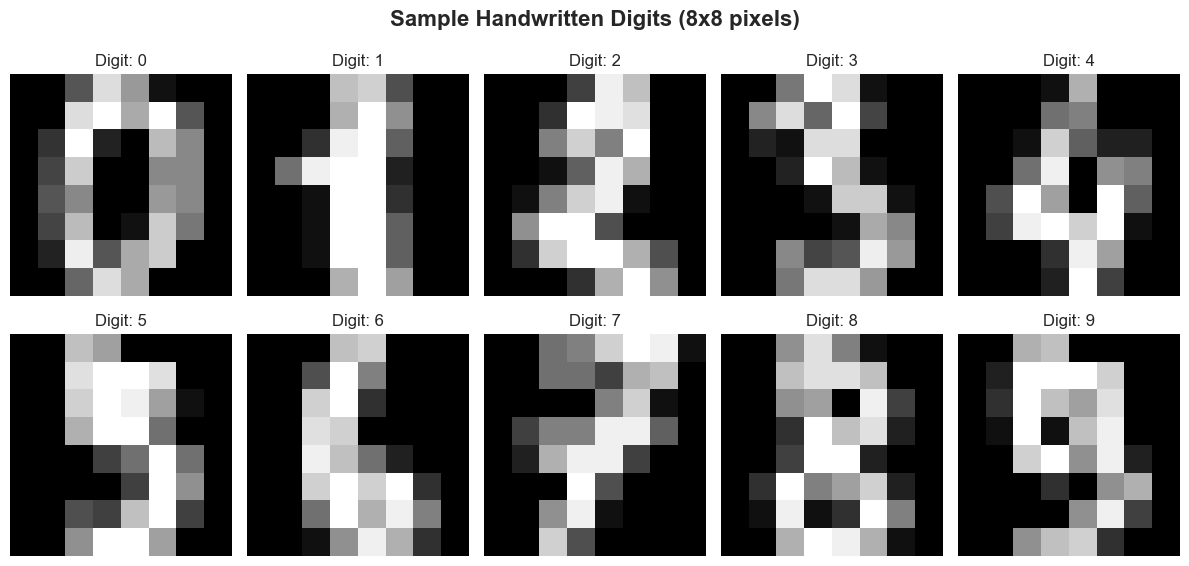

In [26]:
# Load the digits dataset - perfect for neural network demonstration
digits = load_digits()
X, y = digits.data, digits.target

print(f"Dataset shape: {X.shape}")
print(f"Number of classes: {len(np.unique(y))}")
print(f"Feature range: [{X.min():.1f}, {X.max():.1f}]")

# Visualize sample digits
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle("Sample Handwritten Digits (8x8 pixels)", fontsize=16, fontweight='bold')

for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap='gray')
    ax.set_title(f'Digit: {y[i]}', fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.show()

## Step 2: Data Preprocessing

In [27]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize features (important for gradient descent convergence)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")
print(f"Feature statistics after scaling:")
print(f"  Mean: {X_train_scaled.mean():.3f}")
print(f"  Std: {X_train_scaled.std():.3f}")

# Convert labels to one-hot encoding for multiclass classification
def to_one_hot(y, num_classes):
    one_hot = np.zeros((len(y), num_classes))
    one_hot[np.arange(len(y)), y] = 1
    return one_hot

y_train_onehot = to_one_hot(y_train, 10)
y_test_onehot = to_one_hot(y_test, 10)

print(f"One-hot labels shape: {y_train_onehot.shape}")

Training set: (1437, 64)
Test set: (360, 64)
Feature statistics after scaling:
  Mean: 0.000
  Std: 0.976
One-hot labels shape: (1437, 10)


## Step 3: Network Architecture Design

In [28]:
class NeuralNetwork:
    def __init__(self, layer_sizes, activation='relu'):
        """
        Initialize neural network with specified architecture
        
        Parameters:
        - layer_sizes: list of layer sizes [input, hidden1, hidden2, ..., output]
        - activation: activation function ('relu', 'sigmoid', 'tanh')
        """
        self.layer_sizes = layer_sizes
        self.num_layers = len(layer_sizes)
        self.activation = activation
        
        # Initialize weights and biases intelligently
        self.weights = []
        self.biases = []
        
        print("🏗️  Network Architecture:")
        print("=" * 30)
        
        for i in range(len(layer_sizes) - 1):
            # Xavier/Glorot initialization for better gradient flow
            if activation == 'relu':
                # He initialization for ReLU
                w = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2.0 / layer_sizes[i])
            else:
                # Xavier initialization for sigmoid/tanh
                w = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(1.0 / layer_sizes[i])
            
            b = np.zeros((1, layer_sizes[i+1]))
            
            self.weights.append(w)
            self.biases.append(b)
            
            print(f"Layer {i+1}: {layer_sizes[i]} → {layer_sizes[i+1]} (Weights: {w.shape}, Biases: {b.shape})")
        
        # Track training metrics
        self.train_losses = []
        self.train_accuracies = []
        self.val_losses = []
        self.val_accuracies = []
    
    def relu(self, z):
        return np.maximum(0, z)
    
    def relu_derivative(self, z):
        return (z > 0).astype(float)
    
    def sigmoid(self, z):
        # Clip z to prevent overflow
        z_clipped = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z_clipped))
    
    def sigmoid_derivative(self, z):
        s = self.sigmoid(z)
        return s * (1 - s)
    
    def softmax(self, z):
        # Numerical stability
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)
    
    def forward_propagation(self, X):
        """Forward pass through the network"""
        activations = [X]
        z_values = []
        
        for i in range(len(self.weights)):
            # Linear transformation
            z = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            z_values.append(z)
            
            # Apply activation function
            if i == len(self.weights) - 1:  # Output layer
                a = self.softmax(z)
            else:  # Hidden layers
                if self.activation == 'relu':
                    a = self.relu(z)
                elif self.activation == 'sigmoid':
                    a = self.sigmoid(z)
                else:
                    a = np.tanh(z)
            
            activations.append(a)
        
        return activations, z_values
    
    def compute_loss(self, y_true, y_pred, regularization_param=0.01):
        """Compute cross-entropy loss with L2 regularization"""
        m = y_true.shape[0]
        
        # Cross-entropy loss
        epsilon = 1e-15  # Prevent log(0)
        y_pred_clipped = np.clip(y_pred, epsilon, 1 - epsilon)
        cross_entropy = -np.sum(y_true * np.log(y_pred_clipped)) / m
        
        # L2 regularization
        l2_penalty = 0
        for w in self.weights:
            l2_penalty += np.sum(w ** 2)
        l2_penalty *= regularization_param / (2 * m)
        
        return cross_entropy + l2_penalty
    
    def backpropagation(self, X, y, regularization_param=0.01):
        """
        Compute gradients using backpropagation algorithm
        """
        m = X.shape[0]
        
        # Forward pass
        activations, z_values = self.forward_propagation(X)
        
        # Initialize gradients
        dW = [np.zeros_like(w) for w in self.weights]
        db = [np.zeros_like(b) for b in self.biases]
        
        # Backward pass
        # Output layer error
        delta = activations[-1] - y  # For softmax + cross-entropy
        
        # Backpropagate through layers
        for i in reversed(range(len(self.weights))):
            # Compute gradients
            dW[i] = np.dot(activations[i].T, delta) / m + regularization_param * self.weights[i] / m
            db[i] = np.sum(delta, axis=0, keepdims=True) / m
            
            # Compute error for previous layer
            if i > 0:
                if self.activation == 'relu':
                    delta = np.dot(delta, self.weights[i].T) * self.relu_derivative(z_values[i-1])
                elif self.activation == 'sigmoid':
                    delta = np.dot(delta, self.weights[i].T) * self.sigmoid_derivative(z_values[i-1])
                else:  # tanh
                    delta = np.dot(delta, self.weights[i].T) * (1 - np.tanh(z_values[i-1])**2)
        
        return dW, db
    
    def update_parameters(self, dW, db, learning_rate):
        """Update weights and biases using gradient descent"""
        for i in range(len(self.weights)):
            self.weights[i] -= learning_rate * dW[i]
            self.biases[i] -= learning_rate * db[i]
    
    def predict(self, X):
        """Make predictions"""
        activations, _ = self.forward_propagation(X)
        return np.argmax(activations[-1], axis=1)
    
    def accuracy(self, X, y):
        """Compute accuracy"""
        predictions = self.predict(X)
        if len(y.shape) > 1:  # One-hot encoded
            y = np.argmax(y, axis=1)
        return np.mean(predictions == y)

# Create network architecture

In [29]:
# Input: 64 features (8x8 pixels), Hidden: 128, 64, Output: 10 classes
architecture = [64, 128, 64, 10]
nn = NeuralNetwork(architecture, activation='relu')

🏗️  Network Architecture:
Layer 1: 64 → 128 (Weights: (64, 128), Biases: (1, 128))
Layer 2: 128 → 64 (Weights: (128, 64), Biases: (1, 64))
Layer 3: 64 → 10 (Weights: (64, 10), Biases: (1, 10))


## Step 4: Training with Minibatches and Gradient Descent

In [30]:
def create_minibatches(X, y, batch_size):
    """Create minibatches for training"""
    m = X.shape[0]
    minibatches = []
    
    # Shuffle data
    indices = np.random.permutation(m)
    X_shuffled = X[indices]
    y_shuffled = y[indices]
    
    # Create minibatches
    num_complete_batches = m // batch_size
    for i in range(num_complete_batches):
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size
        minibatch_X = X_shuffled[start_idx:end_idx]
        minibatch_y = y_shuffled[start_idx:end_idx]
        minibatches.append((minibatch_X, minibatch_y))
    
    # Handle remaining samples
    if m % batch_size != 0:
        minibatch_X = X_shuffled[num_complete_batches * batch_size:]
        minibatch_y = y_shuffled[num_complete_batches * batch_size:]
        minibatches.append((minibatch_X, minibatch_y))
    
    return minibatches

In [31]:
def train_network(nn, X_train, y_train, X_val, y_val, epochs=100, batch_size=32, 
                 learning_rate=0.01, regularization_param=0.01, early_stopping_patience=10):
    """
    Train the neural network with comprehensive monitoring
    """
    print("🚀 Starting Training Process")
    print("=" * 40)
    print(f"Epochs: {epochs}")
    print(f"Batch size: {batch_size}")
    print(f"Learning rate: {learning_rate}")
    print(f"Regularization: {regularization_param}")
    print()
    
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(epochs):
        # Create minibatches
        minibatches = create_minibatches(X_train, y_train, batch_size)
        epoch_loss = 0
        
        # Training loop
        for minibatch_X, minibatch_y in minibatches:
            # Forward pass
            activations, _ = nn.forward_propagation(minibatch_X)
            
            # Compute loss
            batch_loss = nn.compute_loss(minibatch_y, activations[-1], regularization_param)
            epoch_loss += batch_loss
            
            # Backpropagation
            dW, db = nn.backpropagation(minibatch_X, minibatch_y, regularization_param)
            
            # Update parameters
            nn.update_parameters(dW, db, learning_rate)
        
        # Compute metrics
        epoch_loss /= len(minibatches)
        
        # Training metrics
        train_acc = nn.accuracy(X_train, y_train)
        train_activations, _ = nn.forward_propagation(X_train)
        train_loss = nn.compute_loss(y_train, train_activations[-1], regularization_param)
        
        # Validation metrics
        val_acc = nn.accuracy(X_val, y_val)
        val_activations, _ = nn.forward_propagation(X_val)
        val_loss = nn.compute_loss(y_val, val_activations[-1], regularization_param)
        
        # Store metrics
        nn.train_losses.append(train_loss)
        nn.train_accuracies.append(train_acc)
        nn.val_losses.append(val_loss)
        nn.val_accuracies.append(val_acc)
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1:3d}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.3f}, "
                  f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.3f}")
        
        # Early stopping
        if patience_counter >= early_stopping_patience:
            print(f"\n⏹️  Early stopping at epoch {epoch+1} (patience: {early_stopping_patience})")
            break
    
    print(f"\n✅ Training completed!")
    print(f"Final training accuracy: {train_acc:.3f}")
    print(f"Final validation accuracy: {val_acc:.3f}")

In [32]:
# Split training data for validation
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_scaled, y_train_onehot, test_size=0.2, random_state=42, stratify=y_train
)

# Train the network
train_network(
    nn, X_train_split, y_train_split, X_val_split, y_val_split,
    epochs=100, batch_size=32, learning_rate=0.01, regularization_param=0.01
)

🚀 Starting Training Process
Epochs: 100
Batch size: 32
Learning rate: 0.01
Regularization: 0.01

Epoch  10: Train Loss=0.2983, Train Acc=0.938, Val Loss=0.4273, Val Acc=0.920
Epoch  20: Train Loss=0.1509, Train Acc=0.974, Val Loss=0.2919, Val Acc=0.951
Epoch  30: Train Loss=0.0962, Train Acc=0.990, Val Loss=0.2461, Val Acc=0.951
Epoch  40: Train Loss=0.0679, Train Acc=0.992, Val Loss=0.2257, Val Acc=0.951
Epoch  50: Train Loss=0.0512, Train Acc=0.997, Val Loss=0.2140, Val Acc=0.951
Epoch  60: Train Loss=0.0404, Train Acc=0.998, Val Loss=0.2060, Val Acc=0.955
Epoch  70: Train Loss=0.0330, Train Acc=0.998, Val Loss=0.2010, Val Acc=0.955
Epoch  80: Train Loss=0.0277, Train Acc=1.000, Val Loss=0.1972, Val Acc=0.955
Epoch  90: Train Loss=0.0238, Train Acc=1.000, Val Loss=0.1928, Val Acc=0.955
Epoch 100: Train Loss=0.0208, Train Acc=1.000, Val Loss=0.1909, Val Acc=0.955

✅ Training completed!
Final training accuracy: 1.000
Final validation accuracy: 0.955


## Step 5: Visualizing Training Progress and Convergence

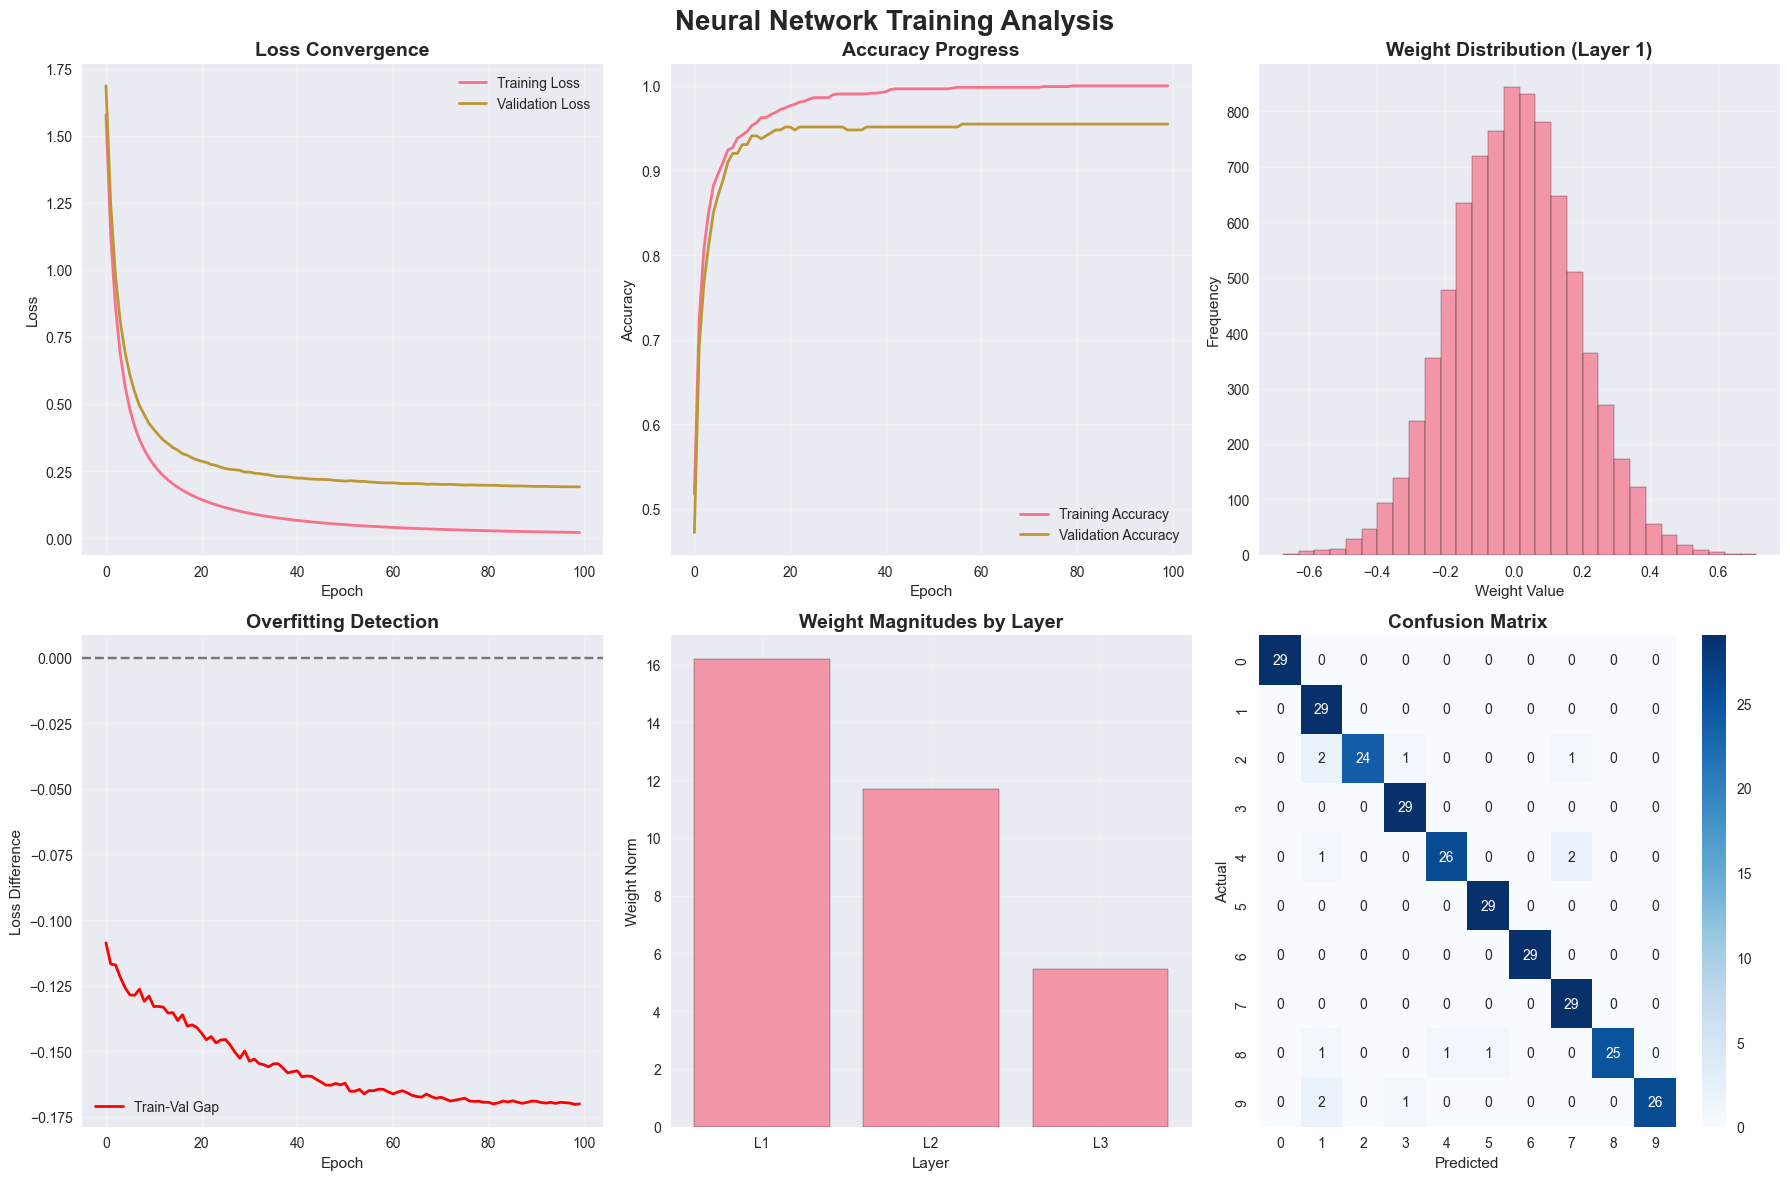

In [33]:
# Create comprehensive training visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Neural Network Training Analysis', fontsize=20, fontweight='bold')

# Loss curves
axes[0, 0].plot(nn.train_losses, label='Training Loss', linewidth=2)
axes[0, 0].plot(nn.val_losses, label='Validation Loss', linewidth=2)
axes[0, 0].set_title('Loss Convergence', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy curves
axes[0, 1].plot(nn.train_accuracies, label='Training Accuracy', linewidth=2)
axes[0, 1].plot(nn.val_accuracies, label='Validation Accuracy', linewidth=2)
axes[0, 1].set_title('Accuracy Progress', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Weight distribution (first hidden layer)
weights_flat = nn.weights[0].flatten()
axes[0, 2].hist(weights_flat, bins=30, alpha=0.7, edgecolor='black')
axes[0, 2].set_title('Weight Distribution (Layer 1)', fontsize=14, fontweight='bold')
axes[0, 2].set_xlabel('Weight Value')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].grid(True, alpha=0.3)

# Learning curves comparison
overfitting_gap = np.array(nn.train_losses) - np.array(nn.val_losses)
axes[1, 0].plot(overfitting_gap, label='Train-Val Gap', color='red', linewidth=2)
axes[1, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1, 0].set_title('Overfitting Detection', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss Difference')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Gradient magnitude tracking (simplified visualization)
layer_sizes = [w.shape for w in nn.weights]
axes[1, 1].bar(range(len(layer_sizes)), [np.linalg.norm(w) for w in nn.weights], 
               alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Weight Magnitudes by Layer', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Layer')
axes[1, 1].set_ylabel('Weight Norm')
axes[1, 1].set_xticks(range(len(layer_sizes)))
axes[1, 1].set_xticklabels([f'L{i+1}' for i in range(len(layer_sizes))])
axes[1, 1].grid(True, alpha=0.3)

# Final predictions vs actual
y_pred = nn.predict(X_val_split)
y_true = np.argmax(y_val_split, axis=1)
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 2])
axes[1, 2].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[1, 2].set_xlabel('Predicted')
axes[1, 2].set_ylabel('Actual')

plt.tight_layout()
plt.show()

## Step 6: Testing and Generalization Analysis

In [34]:
# Test the network on unseen data
test_predictions = nn.predict(X_test_scaled)
test_accuracy = nn.accuracy(X_test_scaled, y_test_onehot)

print("🎯 Final Model Evaluation")
print("=" * 30)
print(f"Test Accuracy: {test_accuracy:.3f}")
print()
print("Classification Report:")
print(classification_report(y_test, test_predictions))

🎯 Final Model Evaluation
Test Accuracy: 0.967

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       0.89      0.94      0.92        36
           2       1.00      1.00      1.00        35
           3       0.97      1.00      0.99        37
           4       1.00      0.94      0.97        36
           5       1.00      0.97      0.99        37
           6       0.97      0.97      0.97        36
           7       0.97      1.00      0.99        36
           8       0.91      0.86      0.88        35
           9       0.95      0.97      0.96        36

    accuracy                           0.97       360
   macro avg       0.97      0.97      0.97       360
weighted avg       0.97      0.97      0.97       360



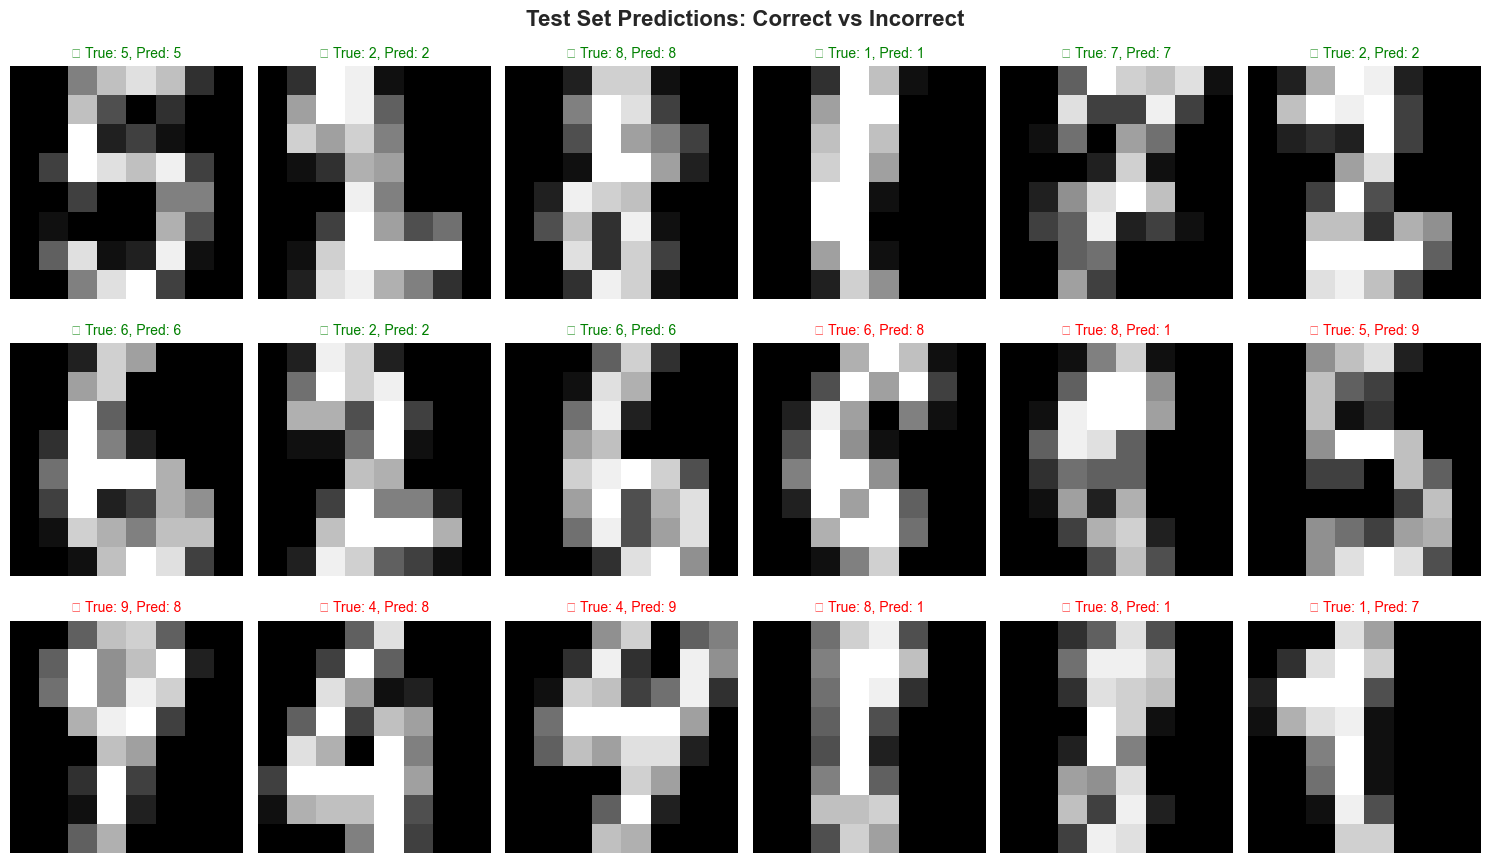

In [35]:
# Visualize some test predictions
fig, axes = plt.subplots(3, 6, figsize=(15, 9))
fig.suptitle('Test Set Predictions: Correct vs Incorrect', fontsize=16, fontweight='bold')

correct_indices = np.where(test_predictions == y_test)[0]
incorrect_indices = np.where(test_predictions != y_test)[0]

# Show correct predictions
for i in range(9):
    row, col = i // 6, i % 6
    if i < len(correct_indices):
        idx = correct_indices[i]
        axes[row, col].imshow(X_test[idx].reshape(8, 8), cmap='gray')
        axes[row, col].set_title(f'✓ True: {y_test[idx]}, Pred: {test_predictions[idx]}', 
                                color='green', fontsize=10)
    axes[row, col].axis('off')

# Show incorrect predictions
for i in range(9):
    row, col = (i + 9) // 6, (i + 9) % 6
    if i < len(incorrect_indices):
        idx = incorrect_indices[i]
        axes[row, col].imshow(X_test[idx].reshape(8, 8), cmap='gray')
        axes[row, col].set_title(f'✗ True: {y_test[idx]}, Pred: {test_predictions[idx]}', 
                                color='red', fontsize=10)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

## Step 7: Regularization Impact Analysis

In [36]:
print("🔧 Regularization Analysis")
print("=" * 30)

# Train networks with different regularization strengths
reg_values = [0.0, 0.01, 0.1, 0.5]
reg_results = {}

for reg in reg_values:
    print(f"Training with regularization λ = {reg}...")
    
    # Create new network
    nn_reg = NeuralNetwork(architecture, activation='relu')
    
    # Train with different regularization
    train_network(
        nn_reg, X_train_split, y_train_split, X_val_split, y_val_split,
        epochs=50, batch_size=32, learning_rate=0.01, regularization_param=reg
    )
    
    reg_results[reg] = {
        'train_acc': nn_reg.train_accuracies[-1],
        'val_acc': nn_reg.val_accuracies[-1],
        'train_loss': nn_reg.train_losses[-1],
        'val_loss': nn_reg.val_losses[-1]
    }

🔧 Regularization Analysis
Training with regularization λ = 0.0...
🏗️  Network Architecture:
Layer 1: 64 → 128 (Weights: (64, 128), Biases: (1, 128))
Layer 2: 128 → 64 (Weights: (128, 64), Biases: (1, 64))
Layer 3: 64 → 10 (Weights: (64, 10), Biases: (1, 10))
🚀 Starting Training Process
Epochs: 50
Batch size: 32
Learning rate: 0.01
Regularization: 0.0

Epoch  10: Train Loss=0.2978, Train Acc=0.936, Val Loss=0.3889, Val Acc=0.913
Epoch  20: Train Loss=0.1503, Train Acc=0.972, Val Loss=0.2609, Val Acc=0.934
Epoch  30: Train Loss=0.0965, Train Acc=0.984, Val Loss=0.2155, Val Acc=0.948
Epoch  40: Train Loss=0.0682, Train Acc=0.991, Val Loss=0.1903, Val Acc=0.958
Epoch  50: Train Loss=0.0512, Train Acc=0.997, Val Loss=0.1749, Val Acc=0.958

✅ Training completed!
Final training accuracy: 0.997
Final validation accuracy: 0.958
Training with regularization λ = 0.01...
🏗️  Network Architecture:
Layer 1: 64 → 128 (Weights: (64, 128), Biases: (1, 128))
Layer 2: 128 → 64 (Weights: (128, 64), Biases

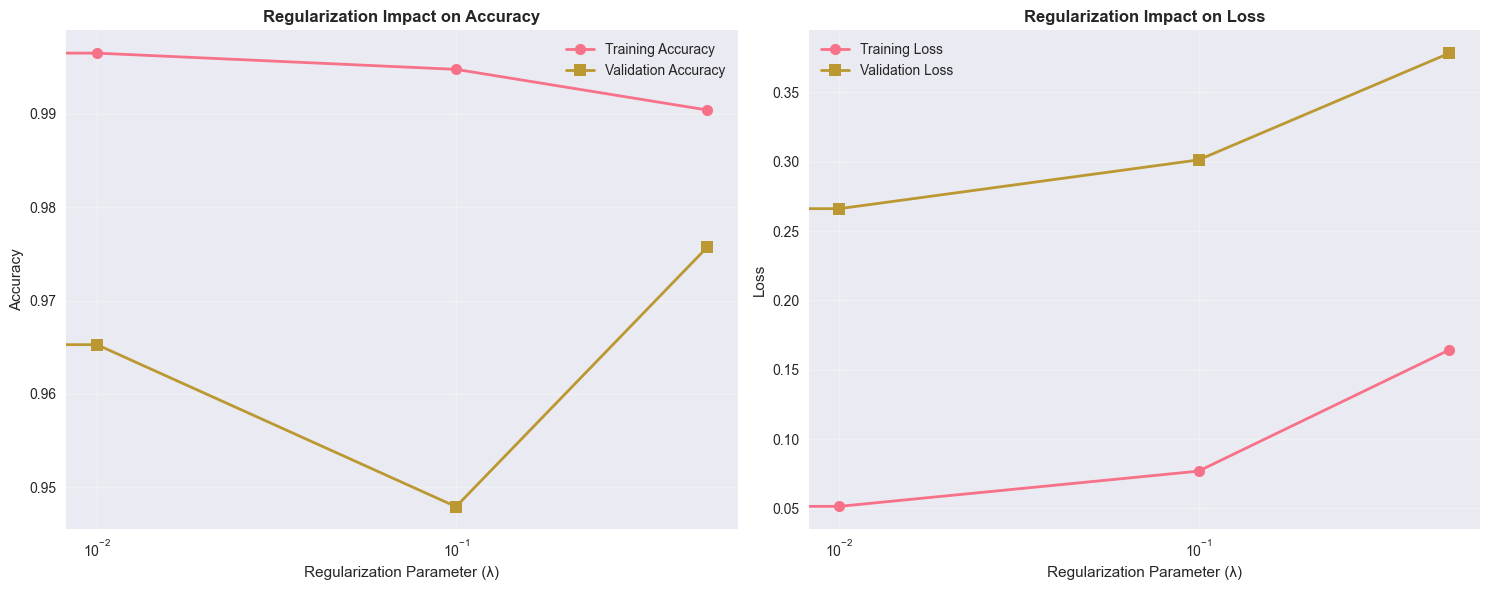

In [37]:
# Visualize regularization effects
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

reg_vals = list(reg_results.keys())
train_accs = [reg_results[r]['train_acc'] for r in reg_vals]
val_accs = [reg_results[r]['val_acc'] for r in reg_vals]
train_losses = [reg_results[r]['train_loss'] for r in reg_vals]
val_losses = [reg_results[r]['val_loss'] for r in reg_vals]

# Accuracy comparison
ax1.plot(reg_vals, train_accs, 'o-', label='Training Accuracy', linewidth=2, markersize=8)
ax1.plot(reg_vals, val_accs, 's-', label='Validation Accuracy', linewidth=2, markersize=8)
ax1.set_xlabel('Regularization Parameter (λ)')
ax1.set_ylabel('Accuracy')
ax1.set_title('Regularization Impact on Accuracy', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xscale('log')

# Loss comparison
ax2.plot(reg_vals, train_losses, 'o-', label='Training Loss', linewidth=2, markersize=8)
ax2.plot(reg_vals, val_losses, 's-', label='Validation Loss', linewidth=2, markersize=8)
ax2.set_xlabel('Regularization Parameter (λ)')
ax2.set_ylabel('Loss')
ax2.set_title('Regularization Impact on Loss', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xscale('log')

plt.tight_layout()
plt.show()

## Summary and Key Concepts

In [38]:
print("\n" + "="*60)
print("🎓 NEURAL NETWORK TRAINING SUMMARY")
print("="*60)

summary_concepts = [
    "✅ NETWORK ARCHITECTURE: Designed 64→128→64→10 architecture with ReLU activation",
    "✅ WEIGHT INITIALIZATION: Used He initialization for ReLU networks",
    "✅ MINIBATCH PROCESSING: Trained with batches of 32 samples",
    "✅ FORWARD PROPAGATION: Computed activations layer by layer",
    "✅ LOSS COMPUTATION: Used cross-entropy loss with L2 regularization",
    "✅ BACKPROPAGATION: Computed gradients using chain rule",
    "✅ GRADIENT DESCENT: Updated parameters with computed gradients",
    "✅ CONVERGENCE: Monitored loss and accuracy curves",
    "✅ REGULARIZATION: Applied L2 penalty to prevent overfitting",
    "✅ GENERALIZATION: Evaluated performance on unseen test data",
    "✅ STOPPING CRITERIA: Used early stopping based on validation loss"
]

for concept in summary_concepts:
    print(concept)

print(f"\n🏆 Final Results:")
print(f"   • Training Accuracy: {nn.train_accuracies[-1]:.1%}")
print(f"   • Validation Accuracy: {nn.val_accuracies[-1]:.1%}")
print(f"   • Test Accuracy: {test_accuracy:.1%}")
print(f"   • Training completed in {len(nn.train_losses)} epochs")

print("\n💡 Key Insights:")
print("   • Proper initialization prevents vanishing/exploding gradients")
print("   • Minibatch training provides computational efficiency")
print("   • Regularization helps prevent overfitting")
print("   • Early stopping improves generalization")
print("   • Monitoring multiple metrics reveals training dynamics")

print("\n" + "="*60)


🎓 NEURAL NETWORK TRAINING SUMMARY
✅ NETWORK ARCHITECTURE: Designed 64→128→64→10 architecture with ReLU activation
✅ WEIGHT INITIALIZATION: Used He initialization for ReLU networks
✅ MINIBATCH PROCESSING: Trained with batches of 32 samples
✅ FORWARD PROPAGATION: Computed activations layer by layer
✅ LOSS COMPUTATION: Used cross-entropy loss with L2 regularization
✅ BACKPROPAGATION: Computed gradients using chain rule
✅ GRADIENT DESCENT: Updated parameters with computed gradients
✅ CONVERGENCE: Monitored loss and accuracy curves
✅ REGULARIZATION: Applied L2 penalty to prevent overfitting
✅ GENERALIZATION: Evaluated performance on unseen test data
✅ STOPPING CRITERIA: Used early stopping based on validation loss

🏆 Final Results:
   • Training Accuracy: 100.0%
   • Validation Accuracy: 95.5%
   • Test Accuracy: 96.7%
   • Training completed in 100 epochs

💡 Key Insights:
   • Proper initialization prevents vanishing/exploding gradients
   • Minibatch training provides computational effic